In [1]:
!pip install pandas_ta
!pip install neat-python


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
import numpy as np
import pandas_ta as ta
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import pickle
import random
import neat
import os
import os.path

In [4]:
def get_relative_change(df, column_name):
    relative_changes = []
    for i in range(len(df)):
        if i == 0:
            relative_changes.append(0)  # First element has no previous value
        else:
            relative_change = (df.iloc[i] - df.iloc[i-1]) / df.iloc[i-1]
            relative_changes.append(relative_change)
    return pd.DataFrame({column_name: relative_changes})

In [5]:
df = pd.read_csv('/content/drive/MyDrive/eurusd_hour.csv')
close = df['AC']
open = df['AO']
high = df['AH']
low = df['AL']


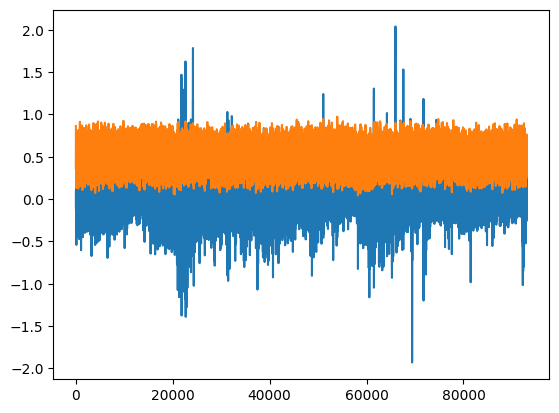

In [6]:
close_np = close.to_numpy()


# Calculate the rolling velocity
RSI = ta.rsi(close,10,scalar=1)
ROC = ta.roc(close,8,scalar=50)
CHANGE = get_relative_change(close,"Change")

INDICATORS = pd.concat([ROC,RSI,CHANGE],axis=1)

INDICATORS = INDICATORS.dropna(axis=0)
INDICATORS = INDICATORS.reset_index()
INDICATORS.pop('index')

change = INDICATORS.pop('Change')
INDICATORS = INDICATORS.to_numpy()
change = change.to_numpy()
change_dev = change.std()
change = change/change_dev


plt.plot(INDICATORS)

In [7]:
def softmax(x):
    y = np.exp(x - np.max(x))
    f_x = y / np.sum(np.exp(x))
    return f_x

In [8]:
def clamp(num, min_value, max_value):
    return max(min(num, max_value), min_value)

In [9]:
outputs = [.6,.7,.8,.10]
action = outputs[:3]
maxed = np.argmax(action)
print(maxed)

2


In [32]:
def run_env_loop(net,rand,debug):
    trade_info = np.zeros(4)
    returns = np.array([])

    trade_timer = 0
    trade_value = 0
    trade_direction = 0
    trade_max = 0
    cash_out_val = 0


    for count in range(rand, rand+1000):
        state = np.concatenate((INDICATORS[count], trade_info))
        outputs = net.activate(state)
        action = np.argmax(outputs)
        buy = True if action == 3 else False
        sell = True if action == 2 else False
        cash_out = True if action == 0 else False
        cur_move = change[count]

        if buy or sell:
          cash_out_value = trade_value
          trade_direction = 1 if buy else -1
          trade_value = (cur_move*trade_direction)-.1
          trade_max = trade_value
          trade_timer = 0
        elif cash_out:
          cash_out_value = trade_value
          trade_direction = 0
          trade_value = 0
          trade_max = 0
          trade_timer = 0
        else:
          cash_out_value = 0
          trade_value = cur_move*trade_direction
          trade_max = max(trade_max,trade_value)
          trade_timer += .1


        trade_info = np.array((trade_direction,trade_value,trade_timer,trade_max))

        if cash_out_value != 0:
            returns = np.append(returns,cash_out_value)
        if debug:
          print(trade_info)

    return np.sum(returns) if len(returns)>1 else 0

In [33]:
def eval_genomes(genomes, config):
  rand = random.randint(0, 10000)
  for genome_id, genome in genomes:
    genome.fitness = 0.0
    net = neat.nn.FeedForwardNetwork.create(genome, config)
    genome.fitness = run_env_loop(net,rand,False)


In [34]:
config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                     neat.DefaultSpeciesSet, neat.DefaultStagnation,
                     '/content/drive/MyDrive/config-feedforward')

p = neat.Population(config)
p.add_reporter(neat.StdOutReporter(False))
#p.add_reporter(neat.Checkpointer(100, 100,filename_prefix="/content/drive/MyDrive/neat/Neetcheckpoint/"))

In [ ]:
winner = p.run(eval_genomes,10)


 ****** Running generation 0 ****** 

Population's average fitness: -20.15223 stdev: 95.98688
Best fitness: 290.70894 - size: (4, 24) - species 1 - id 114
Average adjusted fitness: 0.491
Mean genetic distance 1.291, standard deviation 0.237
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 4.988 sec

 ****** Running generation 1 ****** 

Population's average fitness: 42.72104 stdev: 115.98013
Best fitness: 302.22376 - size: (4, 23) - species 1 - id 185
Average adjusted fitness: 0.551
Mean genetic distance 1.381, standard deviation 0.229
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 6.846 sec (5.917 average)

 ****** Running generation 2 ****** 



In [30]:
net = neat.nn.FeedForwardNetwork.create(winner, config)

In [31]:
run_env_loop(net,6000,True)

[1.         0.98270681 0.         0.98270681]
[ 1.         -1.56243664  0.         -1.56243664]
[ 1.         -0.18731509  0.1        -0.18731509]
[ 1.         -0.30111087  0.2        -0.18731509]
[1.         0.31460909 0.3        0.31460909]
[ 1.         -0.30110596  0.         -0.30110596]
[1.         0.46855908 0.1        0.46855908]
[1.         0.06689879 0.         0.06689879]
[1.         0.26757334 0.         0.26757334]
[1.         0.10030728 0.         0.10030728]
[1. 0. 0. 0.]
[ 1.         -0.20059002  0.         -0.20059002]
[ 1.         -0.42134209  0.1        -0.20059002]
[ 1.         -1.10408221  0.2        -0.20059002]
[ 1.         -0.36852352  0.3        -0.20059002]
[1.         0.34857887 0.4        0.34857887]
[1.         1.12569943 0.         1.12569943]
[1.         0.10037111 0.         0.10037111]
[1.         0.10035883 0.         0.10035883]
[1.         2.40831717 0.         2.40831717]
[-1.          0.18009494  0.          0.18009494]
[ 1.         -0.61379161  0.  

383.305343413011